# Using `memento` to analyze Interferon-B response in monocytes

To install `memento` in the pre-release version (for Ye Lab members), install it directly from github by running:

```pip install git+https://github.com/yelabucsf/scrna-parameter-estimation.git@release-v0.0.3```

This requires that you have access to the Ye Lab organization. 

In [1]:
# This is only for development purposes

import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.7.egg')
import memento
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import scanpy as sc
import memento

In [3]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig4/'
data_path = '/data_volume/parameter_estimation/'

In [4]:
import pickle as pkl

### Read IFN data and filter for monocytes

For `memento`, we need the raw count matrix. Preferrably, feed the one with all genes so that we can choose what genes to look at. 

One of the columns in `adata.obs` should be the discrete groups to compare mean, variability, and co-variability across. In this case, it's called `stim`. 

The column containing the covariate that you want p-values for should either:
- Be binary (aka the column only contains two unique values, such as 'A' and 'B'. Here, the values are either 'stim' or 'ctrl'.
- Be numeric (aka the column contains -1, 0, -1 for each genotype value). 

I recommend changing the labels to something numeric (here, i use 0 for `ctrl` and 1 for `stim`). Otherwise, the sign of the DE/EV/DC testing will be very hard to interpret.

In [20]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
print(adata)

AnnData object with n_obs × n_vars = 5341 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'cell_type'
    var: 'gene_ids', 'mt', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors'
    obsm: 'X_tsne'


In [21]:
adata.obs['stim'] = adata.obs['stim'].apply(lambda x: 1 if x == 'ctrl' else 0)

In [22]:
adata.obs[['ind', 'stim', 'cell']].sample(5)

,ind,stim,cell
index,,,
TCGGCACTCCCACT-1,1488,1,CD14+ Monocytes
CCAATGGAGACTAC-1,1015,0,CD14+ Monocytes
CATGTTACTGTCTT-1,1244,1,CD14+ Monocytes
GACTCCTGTATCTC-1,1244,0,CD14+ Monocytes
CACTAGGACAACCA-1,1244,1,CD14+ Monocytes


### Create groups for hypothesis testing and compute 1D parameters

`memento` creates groups of cells based on anything that should be considered a reasonable group; here, we just divide the cells into `stim` and `ctrl`. But we can easily further divide the cells into individuals by adding the `ind` column to the `label_columns` argument when calling `create_groups`.

Values in the `q_column` is the rough estimate of the overall UMI efficiency across both sampling and sequencing. If `s` is the sequencing saturation, multiply `s` by 0.07 for 10X v1, 0.15 for v2, and 0.25 for v3. This allows you to enter different numbers for each batch, which likely have different saturation numbers. This will NOT account for wildly different sequencing scenarios.

By default, `memento` will consider all genes whose expression is high enough to calculate an accurate variance. If you wish to include less genes, increase `filter_mean_thresh`.

In [23]:
from scipy.sparse.csr import csr_matrix

In [24]:
type(adata.X) == csr_matrix

True

In [25]:
adata.obs['capture_rate'] = 0.07
memento.setup_memento(adata, q_column='capture_rate')

In [26]:
memento.create_groups(adata, label_columns=['stim', 'patient', 'HA20'])

In [27]:
memento.compute_1d_moments(adata,
    min_perc_group=.9) # percentage of groups that satisfy the condition for a gene to be considered. 

### Perform 1D hypothesis testing

`formula_like` determines the linear model that is used for hypothesis testing, while `cov_column` is used to pick out the variable that you actually want p-values for. 

`num_cpus` controls how many CPUs to parallelize this operation for. In general, I recommend using 3-6 CPUs for reasonable peformance on any of the AWS machines that we have access to (I'm currently using a c5.2xlarge instance (8 vCPUs). 

In [28]:
memento.ht_1d_moments(
    adata, 
    formula_like='1 + HA20',
    cov_column='HA20', 
    num_boot=5000, 
    verbose=1,
    num_cpus=6)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done 294 tasks      | elapsed:    7.9s
[Parallel(n_jobs=6)]: Done 794 tasks      | elapsed:   18.2s
[Parallel(n_jobs=6)]: Done 1494 tasks      | elapsed:   33.6s
[Parallel(n_jobs=6)]: Done 1866 out of 1877 | elapsed:   41.8s remaining:    0.2s
[Parallel(n_jobs=6)]: Done 1877 out of 1877 | elapsed:   42.3s finished


In [29]:
result_1d = memento.get_1d_ht_result(adata)

### Debug the 1d analysis

In [30]:
import numpy as np
import seaborn as sns

In [31]:
a = np.log10(result_1d.query('de_coef > 0').de_pval)
b = np.log10(result_1d.query('de_coef < 0').de_pval)

In [32]:
a.mean()

-2.991615156018528

In [33]:
b.mean()

-2.8942563029686825

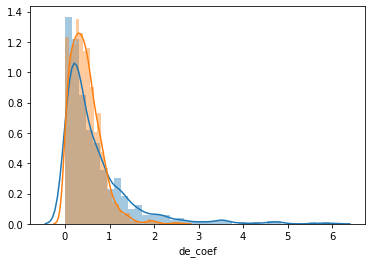

In [25]:
sns.distplot(a)
sns.distplot(b)

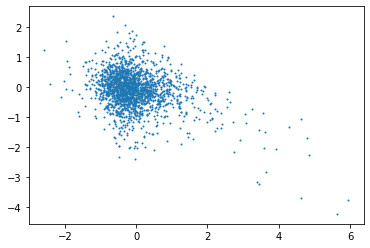

In [21]:
plt.scatter(result_1d.de_coef, result_1d.dv_coef, s=1)

In [16]:
result_1d.query('de_coef > 0').sort_values('de_pval').head(10)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
1729,BST2,1.619183,0.030240,4.726042e-11,-1.111678,0.132104,9.192075e-11
1269,EPSTI1,2.131654,0.050375,3.767094e-10,-1.025535,0.190488,1.490294e-06
37,IFI6,2.743425,0.043400,2.312530e-09,-2.180335,0.119523,1.470124e-18
323,CFLAR,1.569806,0.045022,8.472543e-09,0.168627,0.219047,4.401120e-01
1527,CCL2,1.480777,0.044956,2.187164e-08,-1.518922,0.056469,2.265698e-31
455,LAP3,1.667709,0.041296,3.631985e-08,-1.000204,0.132875,4.097712e-10
1831,APOBEC3A,3.580056,0.053504,3.923568e-08,-2.047863,0.135064,1.466759e-24
521,SGTB,1.255900,0.074715,4.663923e-08,-0.824173,0.491792,1.031794e-01
1041,IRF7,2.082097,0.036321,6.516547e-08,-0.571581,0.165578,1.033833e-04
876,IDO1,3.935713,0.093375,8.349652e-08,-2.081958,0.134573,4.953888e-20


In [22]:
result_1d.query('dv_coef > 0 & de_coef > 0').sort_values('dv_pval').head(10)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
1537,CCR7,0.885639,0.131895,3.107375e-04,0.989507,0.228534,0.000854
1827,LGALS2,1.260535,0.077643,6.922026e-04,0.777082,0.163837,0.001293
114,RHOC,0.196268,0.074374,6.198760e-03,1.256302,0.357530,0.001357
171,FCER1G,0.040256,0.015372,8.998200e-03,0.273272,0.066242,0.001362
811,SAT1,1.165683,0.023603,2.974826e-07,0.581353,0.155072,0.001669
1258,SAP18,0.674537,0.029913,1.014309e-05,0.864380,0.244811,0.002799
1392,RPS27L,0.275792,0.046837,2.273660e-04,0.500192,0.165548,0.003599
1309,FAM177A1,0.767690,0.045756,1.575407e-05,1.380380,0.302860,0.005388
601,SERPINB1,1.089864,0.048661,6.245676e-06,0.487953,0.179763,0.008798
1206,DDIT3,0.462501,0.079067,9.886858e-04,0.800743,0.304791,0.012797


### Perform 2D hypothesis testing

For differential coexpression testing, we can specify which genes you want to perform HT on. It takes a list of pairs of genes, where each element in the list is a tuple. Here, we focus on 1 transcription factor and their correlations to rest of the transcriptome. 

Similar to the 1D case, 2D hypothesis testing scales with the number of pairs of genes to test. If you have a smaller set of candidate genes, it will run faster.

In [27]:
import itertools

In [28]:
gene_pairs = list(itertools.product(['IRF7'], adata.var.index.tolist()))

In [29]:
memento.compute_2d_moments(adata, gene_pairs)

In [30]:
memento.ht_2d_moments(
    adata, 
    formula_like='1 + HA20', 
    cov_column='HA20', 
    num_cpus=13, 
    num_boot=5000)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done   6 tasks      | elapsed:    2.6s
[Parallel(n_jobs=13)]: Done 102 tasks      | elapsed:    7.9s
[Parallel(n_jobs=13)]: Done 262 tasks      | elapsed:   16.2s
[Parallel(n_jobs=13)]: Done 486 tasks      | elapsed:   27.3s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   42.9s
[Parallel(n_jobs=13)]: Done 1126 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 1542 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 1876 out of 1876 | elapsed:  1.7min finished


In [31]:
result_2d = memento.get_2d_ht_result(adata)

In [32]:
result_2d.sort_values('corr_pval').head(10)

,gene_1,gene_2,corr_coef,corr_se,corr_pval
574,IRF7,CD74,0.316101,0.046624,0.000201
638,IRF7,HLA-DRA,0.245894,0.045615,0.000273
317,IRF7,HSPD1,0.252647,0.069947,0.000318
158,IRF7,LMNA,0.311323,0.065483,0.000403
1148,IRF7,HSPA8,0.275049,0.057528,0.000454
74,IRF7,PRDX1,0.269491,0.059490,0.000552
943,IRF7,CTSL,0.203125,0.044701,0.000567
1815,IRF7,SDF2L1,0.306280,0.060610,0.000662
1406,IRF7,PKM,0.308369,0.068599,0.000694
641,IRF7,HLA-DQA1,0.278193,0.055818,0.000717


### Save your results

There are some objects within `memento` that doesn't play nice with scanpy. So just give it a heads up with the `prepare_to_save` function.

In [13]:
memento.prepare_to_save(adata)

In [15]:
adata.write(data_path + 'ifn_tutorial.h5ad')

... storing 'memento_group' as categorical
